In [65]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/time-series-uk-supermarket-data/All_Data_ASDA.csv',parse_dates=['date'])
df.head()


,supermarket,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,ASDA,4.75,19.8,kg,Tassimo Cadbury Hot Chocolate Pods x 8,2024-04-13,drinks,False
1,ASDA,2.00,26.7,kg,Taylors of Harrogate Hot Lava Java Coffee Bags,2024-04-13,drinks,False
2,ASDA,5.00,20.8,kg,Tassimo Limited Edition Cadbury Orange Hot Cho...,2024-04-13,drinks,False
3,ASDA,3.50,15.4,kg,ASDA Extra Special Brazilian Ground Coffee,2024-04-13,drinks,True
4,ASDA,3.50,15.4,kg,ASDA Extra Special Espresso Coffee Beans,2024-04-13,drinks,True


In [66]:
df.columns

Index(['supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date',
       'category', 'own_brand'],
      dtype='object')

In [39]:
df.shape

(2456414, 8)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456414 entries, 0 to 2456413
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   supermarket      object        
 1   prices_(£)       float64       
 2   prices_unit_(£)  float64       
 3   unit             object        
 4   names            object        
 5   date             datetime64[ns]
 6   category         object        
 7   own_brand        object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 149.9+ MB


In [41]:
df = df.sort_values(['supermarket', 'names', 'date'])

In [42]:
target_col = 'prices_unit_(£)'
id_cols = ['supermarket', 'names']
cat_cols = ['supermarket', 'names', 'unit', 'category', 'own_brand']

# EDA

## Overall Trend of average price per unit

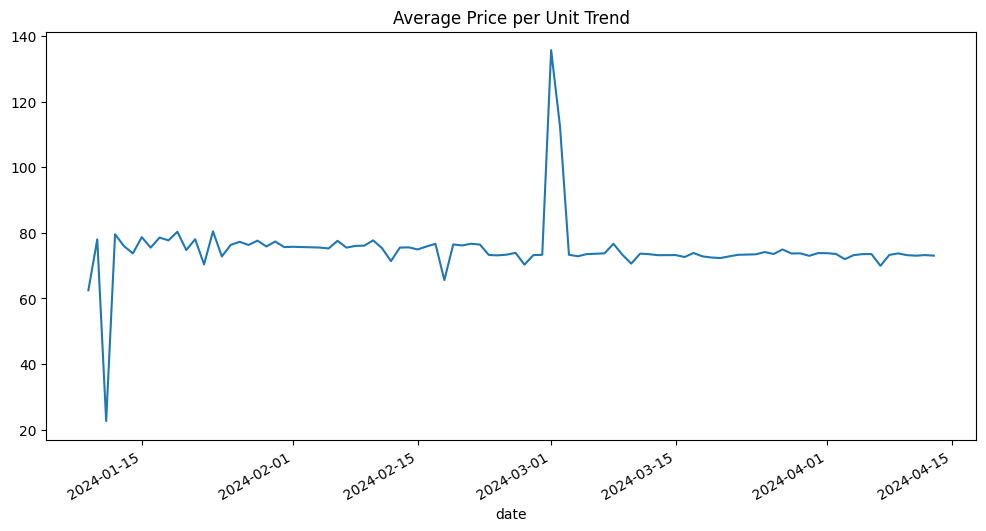

In [43]:
df.groupby('date')[target_col].mean().plot(title='Average Price per Unit Trend', figsize=(12, 6))
plt.show()

## Prices by category

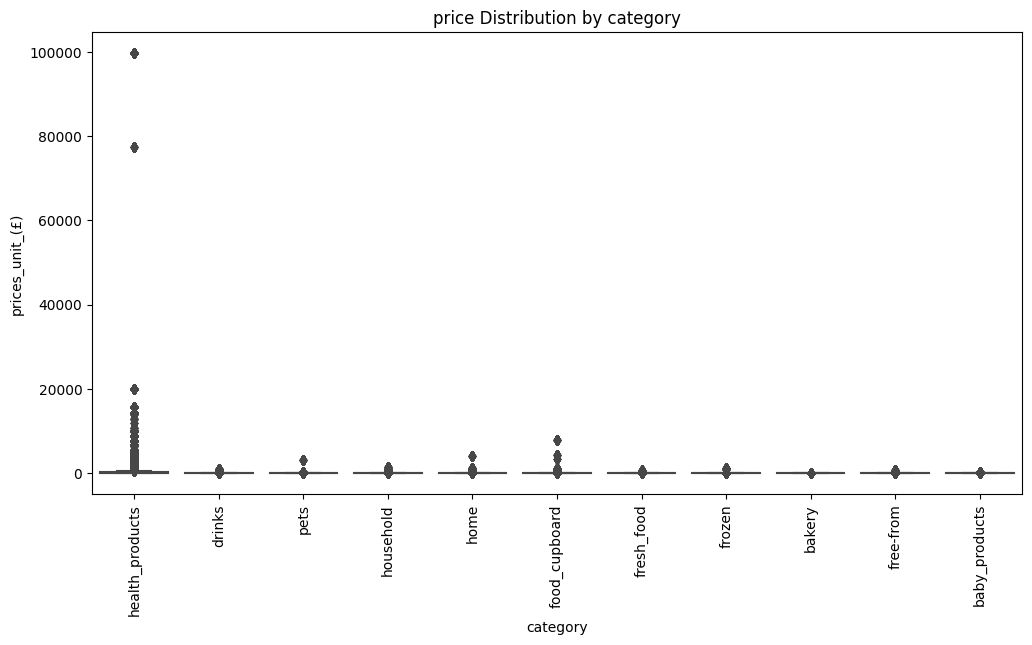

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y=target_col, data=df)
plt.xticks(rotation=90)
plt.title("price Distribution by category")
plt.show()

## Prices for own brand vs not

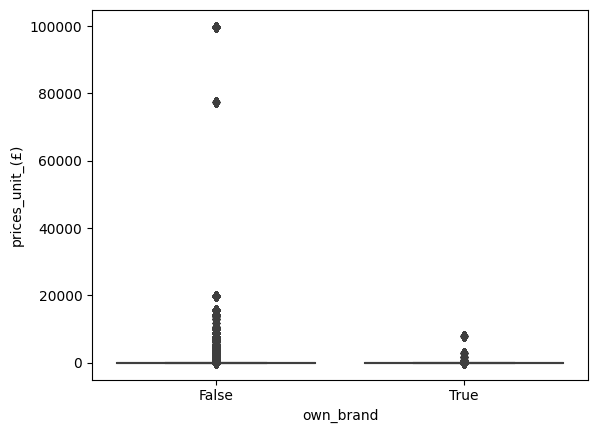

In [45]:
sns.boxplot(x='own_brand', y=target_col, data=df)
plt.show()

# Data Cleaning

## Remove duplicates

In [46]:
df = df.drop_duplicates(subset=id_cols + ['date'])


## Fill missing dates per product-supermarket combination

In [47]:
def complete_date_range(df, id_cols):
    all_idx = pd.MultiIndex.from_product(
        [df[col].unique() for col in id_cols] +
        [pd.date_range(df['date'].min(), df['date'].max(), freq='D')],
        names=id_cols + ['date']
    )
    
    df_full = df.set_index(id_cols + ['date']).reindex(all_idx).reset_index()
    return df_full

df = complete_date_range(df, id_cols)


## Fill missing target values

In [48]:
df[target_col] = df.groupby(id_cols)[target_col].transform(lambda x: x.ffill().bfill())

df[target_col] = df.groupby('category')[target_col].transform(lambda x: x.fillna(x.median()))

df[target_col] = df[target_col].fillna(df[target_col].median())

print(df[target_col].isna().sum()) 


0


## Fill other categorical columns


In [49]:
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# Feature Engineering

## Time features

In [50]:
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['dayofmonth'] = df['date'].dt.day
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

## Lag & Rolling Features

In [51]:
def create_lag_rolling_features(df, group_cols, target_col, lags=[1,7,14], roll_windows=[7,30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    for w in roll_windows:
        df[f'roll_mean_{w}'] = df.groupby(group_cols)[target_col].shift(1).rolling(w).mean()
        df[f'roll_std_{w}'] = df.groupby(group_cols)[target_col].shift(1).rolling(w).std()
    df = df.dropna().reset_index(drop=True)
    return df

df = create_lag_rolling_features(df, id_cols, target_col)

## Encode Categorical Features

In [52]:
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

# Train/Test Split

In [53]:
horizon = 30   
max_date = df['date'].max()

train = df[df['date'] <= (max_date - pd.Timedelta(days=horizon))]
test  = df[df['date']  > (max_date - pd.Timedelta(days=horizon))]

X_train = train.drop(columns=[target_col,'date'])
y_train = train[target_col]
X_test  = test.drop(columns=[target_col,'date'])
y_test  = test[target_col]

#  Model & Hyperparameter Tuning

In [55]:
lgb_model = lgb.LGBMRegressor(random_state=42)

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 231612, number of used features: 16
[LightGBM] [Info] Start training from score 17.364294
[CV] END colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=31, subsample=1.0; total time=   8.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 463221, number of used features: 16
[LightGBM] [Info] Start training from score 34.781048
[CV] 

# Predict & Evaluate

In [ ]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f" Test RMSE: {rmse:.3f}")
print(f" Test MAPE: {mape:.3f}")



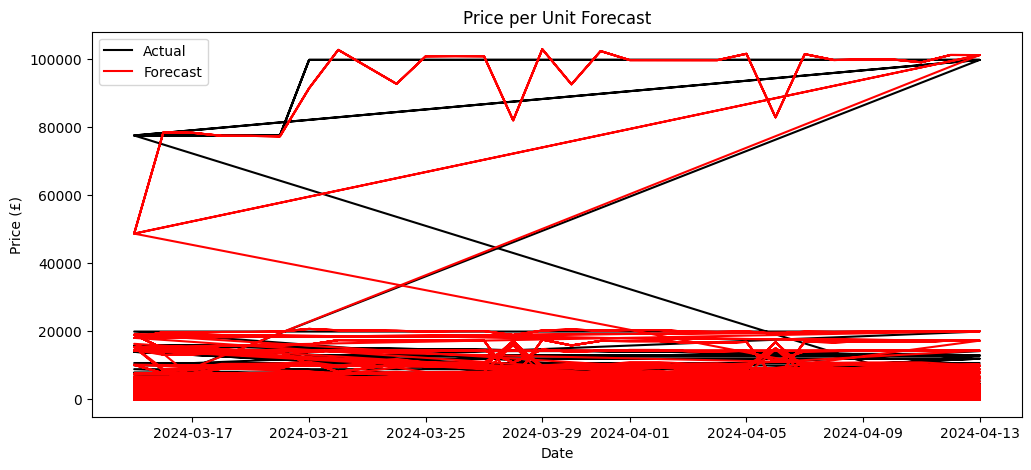

In [58]:
plt.figure(figsize=(12,5))
plt.plot(test['date'], y_test, label='Actual', color='black')
plt.plot(test['date'], y_pred, label='Forecast', color='red')
plt.title("Price per Unit Forecast")
plt.xlabel("Date")
plt.ylabel("Price (£)")
plt.legend()
plt.show()

In [64]:
import joblib
joblib.dump(best_model, '/kaggle/working/best_model.pkl')

['/kaggle/working/best_model.pkl']